# Text Clustering

## Need datasets are in the current folder structure in the github repo
## Look for 'adjustable' comments to adjust various settings 

```
Author: hong cui
Dataset:iSamples
```

In [1]:
from platform import python_version
print(python_version()) #3.9.7

3.9.7


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import fasttext # pip install fasttext-0.9.2-cp310-cp310-win_amd64.whl
import matplotlib.pyplot as plt 
import pickle
from joblib import Parallel, delayed
from sklearn.cluster import Birch
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Load and preprocess data: selective fields


In [3]:
ds = "GEOME"

data = pd.read_csv(ds+'.txt',sep='#', keep_default_na=False)

data.columns.tolist()

df_content = pd.DataFrame()
#adjustable: select different (conbinations) of the files for 'orginal'
df_content['original'] = data['parent_habitat'].astype(str) + ' '+ data['parent_microHabitat'].astype(str) 
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #228457
df_content
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content
df_content.columns
df_content.shape[0] #99321
df_content.iloc[3]


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,52,85,98,100,120,131,172) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['parent_decimalLongitude',
 'record_genbankSpecimenVoucher',
 'parent_timeOfDay',
 'record_weight',
 'record_subTribe',
 'parent_landowner',
 'parent_environmentalMedium',
 'children_img512',
 'children_photographer',
 'children',
 'record_taxonRemarks',
 'parent_projectId',
 'record_subPhylum',
 'parent_expeditionCode',
 'record_fieldNumber',
 'record_preservative',
 'parent_maximumElevationInMeters',
 'record_phylum',
 'parent_horizontalDatum',
 'record_fixative',
 'children_measurementDeterminedDate',
 'parent_waterBody',
 'children_diagnosticLab',
 'children_tissueBarcode',
 'record_modifiedReason',
 'record_associatedMedia',
 'parent_municipality',
 'parent_fieldNotes',
 'children_diseaseLineage',
 'children_tissueRemarks',
 'record_references',
 'record_collectionCode',
 'record_morphospeciesDescription',
 'record_occurrenceID',
 'children_filename',
 'record_lifeStage',
 'children_tissueSamplingMonth',
 'parent_minimumElevationInMeters',
 'record_previousIdentifications',
 'rec

228457

,original
0,in Pocillopora and Acropora rubble
1,NaN
2,Pocillopora_Acropora rubble
3,Pocillopora_Acropora rubble
4,NaN
...,...
228452,NaN
228453,NaN
228454,NaN
228455,NaN


,original
0,in Pocillopora and Acropora rubble
1,Pocillopora_Acropora rubble
2,Pocillopora_Acropora rubble
3,Pocillopora_Acropora rubble
4,in Pocillopora and Acropora rubble
...,...
99316,in Pocillopora_Acropora rubble
99317,in Pocillopora_Acropora rubble
99318,in Pocillopora_Acropora rubble
99319,Pocillopora_Acropora rubble


Index(['original'], dtype='object')

99321

original     Pocillopora_Acropora rubble
Name: 3, dtype: object

In [4]:
nltk.download('stopwords')
#adjustable: add collection-specific stop words to the list
estopwords = stopwords.words('english')+["sample", "samples", "sampling", "sampled", "sample_id", "cm"]
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\updates\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import string
def clean(line):
    if pd.isna(line):
        return ''
    else:
        newline =''
        for token1 in re.split(r'#+', line):
            for token2 in token1.split():
                token2 = token2.lower()
                if token2.startswith('https://') or token2.startswith('http://') or re.match(".*?\d.*", token2) or len(token2)<=2 or token2 in estopwords:
                    next
                else:
                    token2 = token2.strip(string.punctuation)
                    for token3 in re.split(r'[/<>.]', token2):
                        if len(token3)<=2 or token3 in estopwords:
                            next
                        else:
                            newline = newline+' '+token3
                        
        return newline.strip()
    
    
# line = "event###records found and at https://wwww.applies.com/###12 cm. l.d. ###width 1dm ###rock>mineral>blue mineral###"    
# line = '""#""#""#""#"74"#""#""#"74"#""#""#""#""#""#""#""#""#"2020"#""#""#"University of Florida"#""#"23.8361515"#""#""#""#""#""#""#"Alpheidae sp. 1"#""#""#""#""#""#"BOMAN_3342"#""#""#""#""#""#"Oman"#""#"NSF_OMAN"#""#""#""#""#""#""#""#""#"OMAN_020A"#""#""#""#"NSF_OMAN"#""#""#""#""#""#""#"1"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"57.9767976"#""#"Event"#""#""#""#""#"Sample"#""#""#""#""#""#""#"in Pocillopora and Acropora rubble"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Damanyat Islands, S of June Island"#""#""#""#""#""#""#""#""#""#""#""#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"74"#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Muscat Governorate"#""#""#"OMAN_020A"#""#"Arthropoda"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""'
# re.split(r'#+', line)
# newline = clean(line)
# newline


plines = list()
%time plines = Parallel(n_jobs=4)(delayed(clean)(line) for line in df_content['original'])

df_content['content'] = plines
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #99321
df_content.drop_duplicates(subset='content', ignore_index=True, inplace=True) #remove redundant rows
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content.shape[0] #1971
df_content['src'] = ds #add src
plines = df_content['content']

print(plines[0:5])

Wall time: 1.95 s


99321

1971

0    pocillopora acropora rubble
1    pocillopora_acropora rubble
2                           wall
3                  dead acropora
4                          rocks
Name: content, dtype: object


## Form the dataset: use pre-trained word vectors to obtain sentence vector for our corpus 
wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz



In [6]:
%time model = fasttext.load_model('../cc.en.300.bin') #takes 7GB

Wall time: 9.63 s


In [7]:
vlines = list() #records represented as vectors
for pline in plines:
    vlines.append(model.get_sentence_vector(pline))

#normalize to unit vector
vlines = normalize(vlines, axis=1)
del model #reclaim memory


## Estimate number of clusters


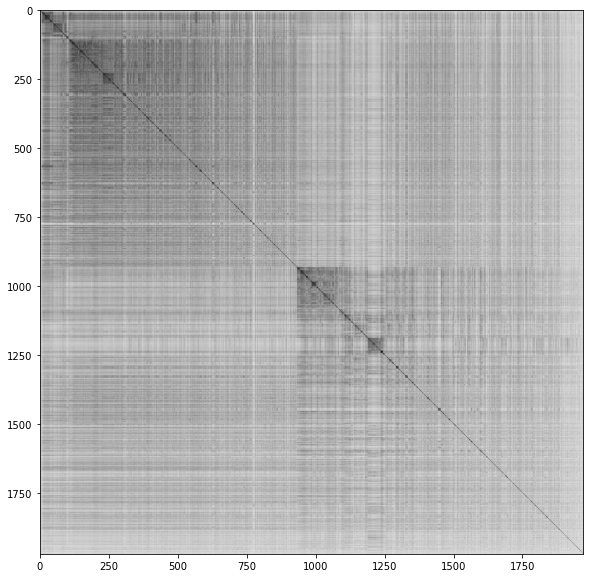

In [8]:
from pyclustertend import vat

#1000 and 5000 samples give very similar vat graph.
#adjustable: len count adjustable, but when it is greater than 3000, it will take time to draw a vat
if len(vlines) > 2000:
    samples = vlines[np.random.choice(vlines.shape[0], 2000, replace=False), :]
    vat(samples) #take data matrix, not dist matrix
else:
    vat(vlines) 

## BIRCH clustering: upper level raw clustering 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [9]:
#adjustable: all three parameters are adjustable. 
#branching_factor: greater gives more natural cluatering results
#n_clusters: total clusters to output. If set to None, subclusters will be returned directly (and not merged into clusters)
#threshold: Euclidean distance threshold for merging subclusters. Sensitive. Set n_clusters to None and experiment with 0.5, 0.55, etc. to observe the number of subclusters generated.

brc = Birch(branching_factor=200, n_clusters=10, threshold=0.5) #n_clusters = None, meaning unlimited  
%time brc.fit(vlines) 
brc.subcluster_labels_



Wall time: 147 ms


Birch(branching_factor=200, n_clusters=10)

array([7, 7, 6, 0, 9, 7, 0, 7, 2, 2, 7, 9, 9, 5, 6, 7, 6, 6, 2, 6, 6, 2,
       6, 7, 7, 6, 7, 7, 2, 7, 2, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6,
       6, 6, 9, 4, 9, 0, 9, 7, 7, 9, 7, 1, 1, 7, 4, 3, 1, 3, 7, 7, 8, 3,
       8, 3, 3, 8, 8, 8, 1, 8, 8, 8, 3, 8, 7, 8, 8, 0, 0, 2, 3, 0, 4, 9,
       7, 7, 4, 7, 4, 0, 2, 0, 2, 3, 7, 4, 3, 3, 3, 0, 3, 6, 3, 4, 3, 3,
       6, 3, 4, 8, 6, 3, 6, 0, 2, 0, 6, 5, 6, 6, 6, 9, 0, 0, 3, 8, 6, 8,
       2, 1, 2, 3, 3, 3, 2, 1, 1, 3, 1, 2, 2, 3, 1, 3, 3, 8, 6, 6, 3, 2,
       8, 2, 3, 8, 3, 3, 3, 3, 6, 3, 3, 1, 3, 3, 3, 0, 3, 2, 8, 2, 2, 2,
       8, 1, 6, 6, 6, 6, 2, 2, 6, 6, 2, 6, 6, 6, 2, 2, 1, 2, 3, 1, 3, 8,
       6, 1, 2, 6, 3, 1, 1, 1, 6, 3, 2, 3, 3, 3, 8, 2, 3, 1, 3, 3, 8, 8,
       0, 3, 1, 1, 6, 6, 6, 2, 5, 5, 5, 6, 5, 6, 5, 1, 3, 1, 1, 5, 1, 1,
       1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3, 1, 8, 6, 7, 2, 2, 2, 2, 2,
       2, 3, 2, 3, 2, 2, 1, 1, 2, 8, 2, 2, 2, 1, 3, 2, 2, 1, 3, 1, 0, 9,
       9, 5, 7, 5, 5, 7, 7, 9, 3, 0, 9, 7, 3, 3, 7,

In [10]:
labels = brc.predict(vlines)
df = pd.DataFrame({'src':df_content['src'], 'birchcluster':labels, 'content':plines, 'original':df_content['original']}) 
df 
tab = df.groupby(['src', 'birchcluster']).size()
#display # of observations in each of the clusters
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tab.unstack().transpose())
   


,src,birchcluster,content,original
0,GEOME,2,pocillopora acropora rubble,in Pocillopora and Acropora rubble
1,GEOME,2,pocillopora_acropora rubble,Pocillopora_Acropora rubble
2,GEOME,0,wall,on wall
3,GEOME,2,dead acropora,on dead Acropora
4,GEOME,0,rocks,under rocks
...,...,...,...,...
1966,GEOME,0,good coral cover,"Good coral cover, 10 m."
1967,GEOME,4,oysters artificial substratum,oysters on artificial substratum
1968,GEOME,0,steep contour dense coral cover,"Very steep contour with dense coral cover, 18 m."
1969,GEOME,8,pocosin,Pocosin


src           GEOME
birchcluster       
0               790
1               103
2               120
3               217
4               304
5                23
6               116
7                70
8               182
9                46


In [11]:
#Gethering terms using TFIDF 

def gatherTerm(cframe, threshold = 0.1):
    #adjustable: max_df: [0-1] maximal precentage of the documents containing the word, Set to 1 would make all words eligible, 0, no words eligible .
    #min_df: [0-1] minimal precentage of the documents containing the word, Set to 1 would make essentially no words eligible, 0, all words are eligible.
    #max_features: max number of eligible words will be selected to make the tfidf matrix
    #more settings see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_vectorizer = TfidfVectorizer(max_df = 1, max_features=500, min_df=0, stop_words='english',
                                  use_idf=True)
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(cframe['description'])
        terms = tfidf_vectorizer.get_feature_names()
        ordered_index = tfidf_matrix.toarray().argsort()[:, ::-1]

        allterms = []
        for i in range(0, len(cframe)):
            n_terms = []
            for ind in ordered_index[i,]: 
                if tfidf_matrix[i, ind] > threshold:
                    n_terms.append(terms[ind]) 
            allterms.append(n_terms)
        return allterms
        
    except ValueError:#no term obtained from tfidf when all records holds the same set of terms
        return []

In [12]:
#produce terms from Birch clustering result

frame = df[['birchcluster','content']]
frame = frame.rename(columns={'birchcluster':'cluster', 'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
#adjustable: threshold > 0
terms = gatherTerm(cframe, threshold=0.1)
i=0
for term in terms:
    print('cluster '+ str(cframe.iloc[i]['cluster'])+':')
    print(term)
    i = i+1
    print()




cluster 0:
['crest', 'corals', 'barrier', 'bommies', 'groove', 'fine', 'overhangs', 'hard', 'brushed']

cluster 1:
['citrus', 'orchard', 'papaya', 'wild', 'cucumber', 'pinus', 'vial', 'agricultural', 'flower', 'caribaea', 'orange']

cluster 2:
['invasive', 'sophora', 'tomentosa', 'myrsinae', 'damicornis', 'nucifer', 'falcatoria', 'scaevola', 'tectorius', 'spp', 'stegastes', 'equisetifolia', 'stipes', 'albizia']

cluster 3:
['palm', 'drainage', 'away', 'nest', 'vine', 'interior', 'marae', 'inacarpus', 'rhizomes', 'gulch', 'densley', 'shrubby', 'cashurina', 'cerbera', 'gills', 'fagiferus', 'desert', 'mound', 'bird', 'phase', 'steam', 'moist']

cluster 4:
['benthic', 'marsh', 'salt', 'neritic', 'phyllospadix', 'chapman', 'mudflat', 'pelagic', 'marginal', 'eelgrass', 'mussel', 'washings', 'brackish', 'mass']

cluster 5:
['cvb', 'publique', 'plage', 'pao', 'lac', 'route', 'vigna', 'ypt', 'sable', 'récifs', 'vaginatum', 'tahiti', 'nursery']

cluster 6:
['crête', 'dans', 'vallon', 'allophylus

## clustering of subclusters of BIRCH result with parallal programming
https://www.machinelearningplus.com/python/parallel-processing-python/# not working!

https://github.com/yngvem/parallelising-python 

also see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

https://github.com/mdimura/sparsehc-dm

https://pypi.org/project/fastcluster/

https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html


In [13]:
from fastcluster import linkage_vector
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram


#birchcluster_df: the input observation data (D=300xN)
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#min_obs: minimal observations in birchcluster_df to run hierarichal clustering, must be >=2

def h_clustering_fast(birchcluster_df, birchcluster_number, link_method, min_obs=2):
    if len(birchcluster_df) < min_obs:
        return [] 
    else:
        linkage_matrix = fastcluster.linkage_vector(birchcluster_df, link_method) #single, complete, average, weighted, median, centroid, ward
        return linkage_matrix
    
#result = h_clustering_fast(vlines[df.index[df['birchcluster']==0]], 0, 'ward', 20)
#result
    

In [14]:
#birchcluster_df: df holding the birchcluster observation content
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#linkage_matrix: the linkage_matrix for the birchcluster
#t: threshold to obtain clusters from hierarchical clustering for the specified criterion
#criterion: criterion used to obtain clusters

def obtain_h_clusters(birchcluster_df, birchcluster_number, linkage_matrix, t=10, criterion="maxclust"):
    if np.any(linkage_matrix):
        clusters = fcluster(linkage_matrix, t, criterion=criterion) #distance, inconsistency
        
        num_clusters = len(np.unique(clusters))
        
        birchcluster_df = birchcluster_df.reset_index()
        cresult = birchcluster_df[['index']]
        cresult['hcluster']= clusters
        
        records = {'description':df[df['birchcluster']==birchcluster_number].content, 'cluster':clusters, 'birchcluster':birchcluster_number}
        frame = pd.DataFrame(records, columns=['description', 'cluster', 'birchcluster'])
        cframe =frame.groupby('cluster', as_index = True).agg({'description': ' '.join})
        return cresult
    else:
        return []
    
#TODO: can't use distance criterion, test other criterion options
    
#len(results)
#16 empty
#cresult = obtain_h_clusters(df[df['birchcluster']==3], 3, linkage_matrix=results[3], t=3 if df[df['birchcluster']==3].shape[0] < 100 else 10 , criterion="maxclust")
#cresult
    
       
            


In [15]:
results = []  
#adjustable: linkmethod: single, complete, average, weighted, median, centroid, ward. Not recommend 'single' for samples dataset.
#min_obs >= 2, minimal number of observations in a cluster to form further clusters

%time results = Parallel(n_jobs=8, verbose=1)(delayed(h_clustering_fast)(vlines[df.index[df['birchcluster']==c]], c, link_method='ward', min_obs=2)  for c in range(0, len(df.birchcluster.unique())))
print("# of linkage matrices obtained: "+str(len(results)))

#adjustable: t, number of final/leaf clusters from hierarchical clustering
cresultlist = []
for cresult in Parallel(n_jobs=8,verbose=1)(delayed(obtain_h_clusters)(df[df['birchcluster']==c], c, linkage_matrix=results[c], t=3 if df[df['birchcluster']==c].shape[0] < 100 else 10, criterion='maxclust') for c in range(0, len(df.birchcluster.unique()))):
    cresultlist.append(cresult)

combined = pd.DataFrame()
#concat list of cresult row-wise
for cresult in cresultlist:
    print("cresult:")
    print(cresult)
    combined = pd.concat([combined, cresult], ignore_index=True)

 
combined.set_index('index', inplace=True)
print(df)
df = df.join(combined) #this is the output df
print(df)

     



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


Wall time: 1.18 s
# of linkage matrices obtained: 10


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


cresult:
     index  hcluster
0        2         3
1        4         1
2        5         2
3        6        10
4        9         1
..     ...       ...
785   1964        10
786   1965         1
787   1966        10
788   1968        10
789   1970        10

[790 rows x 2 columns]
cresult:
     index  hcluster
0       87         2
1      108         2
2      581         3
3      623         8
4      627         6
..     ...       ...
98    1923        10
99    1932         8
100   1934         1
101   1946        10
102   1948         9

[103 rows x 2 columns]
cresult:
     index  hcluster
0        0         3
1        1         3
2        3         2
3       31         1
4       78         1
..     ...       ...
115   1941         4
116   1943        10
117   1944         6
118   1945         8
119   1956        10

[120 rows x 2 columns]
cresult:
     index  hcluster
0       16         4
1       17         4
2       19         4
3       21         4
4       77         3
..     ...

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.5s finished


In [16]:
#produce terms from Birch + hierarchical clustering results

df["cluster"] = df["birchcluster"].astype(str) +'-'+ df["hcluster"].astype(str)
frame = df[['cluster','content']]
frame = frame.rename(columns={'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
terms = gatherTerm(cframe, 0.1)
i=0
allterms = list()
for term in terms:
    print('cluster '+cframe.iloc[i]['cluster']+':')
    print(term)
    i = i+1
    print()
    allterms.extend(term)

from collections import Counter
counter = Counter(allterms)
counter.most_common()
      


cluster 0-1:
['sparse', 'outcrops', 'holothurians', 'shoreadjascent', 'scuzzy', 'sparsely', 'uder', 'outcropping', 'rus', 'colonies', 'mboli', 'tufting', 'pumped', 'spure']

cluster 0-10:
['strong', 'mark', 'poor', 'bleaching', 'chanel', 'passe', 'impacted', 'urchins', 'buoy', 'apparent', 'newly', 'vairae', 'resort', 'miles', 'reefs', 'vicinity', 'minor', 'phormidium', 'spawning', 'uplifted', 'unsanded', 'ruble', 'opposite', 'sedimentation', 'terpios', 'sanded', 'topographically', 'overhand', 'threat', 'tip', 'recruitment', 'tidepools', 'worm', 'places', 'puka', 'quite', 'xestospongia', 'xenia', 'sponges', 'spread', 'sortant']

cluster 0-2:
['olive', 'packed', 'limestone', 'soupy', 'driftwood', 'seagrasss', 'seine', 'shelly', 'outcrop', 'occassional', 'protected', 'wreck', 'push']

cluster 0-3:
['vertical', 'hollows', 'cement', 'slight', 'platform', 'selaginella', 'slimey', 'tube', 'mosses']

cluster 0-4:
['prior']

cluster 0-5:
['cap']

cluster 0-6:
['formation', 'vacuumed', 'gentle',

[('sparse', 1),
 ('outcrops', 1),
 ('holothurians', 1),
 ('shoreadjascent', 1),
 ('scuzzy', 1),
 ('sparsely', 1),
 ('uder', 1),
 ('outcropping', 1),
 ('rus', 1),
 ('colonies', 1),
 ('mboli', 1),
 ('tufting', 1),
 ('pumped', 1),
 ('spure', 1),
 ('strong', 1),
 ('mark', 1),
 ('poor', 1),
 ('bleaching', 1),
 ('chanel', 1),
 ('passe', 1),
 ('impacted', 1),
 ('urchins', 1),
 ('buoy', 1),
 ('apparent', 1),
 ('newly', 1),
 ('vairae', 1),
 ('resort', 1),
 ('miles', 1),
 ('reefs', 1),
 ('vicinity', 1),
 ('minor', 1),
 ('phormidium', 1),
 ('spawning', 1),
 ('uplifted', 1),
 ('unsanded', 1),
 ('ruble', 1),
 ('opposite', 1),
 ('sedimentation', 1),
 ('terpios', 1),
 ('sanded', 1),
 ('topographically', 1),
 ('overhand', 1),
 ('threat', 1),
 ('tip', 1),
 ('recruitment', 1),
 ('tidepools', 1),
 ('worm', 1),
 ('places', 1),
 ('puka', 1),
 ('quite', 1),
 ('xestospongia', 1),
 ('xenia', 1),
 ('sponges', 1),
 ('spread', 1),
 ('sortant', 1),
 ('olive', 1),
 ('packed', 1),
 ('limestone', 1),
 ('soupy', 1),


In [17]:
#see corresponding content
df[(df['birchcluster']==0) & (df['hcluster']==10)]

,src,birchcluster,content,original,hcluster,cluster
6,GEOME,0,coral reef,Coral Reef,10,0-10
26,GEOME,0,fringing reef shallow high flow,fringing reef Shallow high flow,10,0-10
49,GEOME,0,reef,reef,10,0-10
98,GEOME,0,uplifted shore emergent reef,uplifted shore emergent reef,10,0-10
99,GEOME,0,patch reef channel coral sand,patch reef in channel coral and sand,10,0-10
...,...,...,...,...,...,...
1963,GEOME,0,patch reef blue-green ball sponge,Patch Reef with Blue-green and ball sponge.,10,0-10
1964,GEOME,0,within spawning aggregation,"Within spawning aggregation, 10.5 m.",10,0-10
1966,GEOME,0,good coral cover,"Good coral cover, 10 m.",10,0-10
1968,GEOME,0,steep contour dense coral cover,"Very steep contour with dense coral cover, 18 m.",10,0-10
